# **Abstract**

The automotive business has accelerated in recent years due to increased
industrialization and globalization. Bike sharing systems are the new
generation of traditional bike rentals where whole process from
membership, rental and the return has become automatic. Through these
systems, user can easily rent a bike from a particular position and return
at another position. Currently, there are about over 500 bike-sharing
programs around the world which is composed of over 500 thousand
bicycles. Today, there exists great interest in these systems due to their
important role in traffic, environmental and health issues. Therefore,
forecasting the demand on bike rentals is essential for the company to
expand.
Apart from interesting real-world applications of bike sharing systems,
the characteristics of data being generated by these systems make them
attractive for the research. Opposed to other transport services such as bus
or subway, the duration of travel, departure and arrival position is
explicitly recorded in these systems. These features turns bike sharing
system into a virtual sensor network that can be used for sensing mobility
in the city.

# **Introduction**

The primary objective of the project is to develop different regression models using ML
techniques & algorithms to predict the growth of bike rental market on
upcoming years. The better model is chosen based on the accuracy of prediction. We have two years of bike rental data, which includes
essential information like the date of rental, weather condition and number of bikes rented during the
year. 

This article is organized as follows. In Section I, Data cleaning and Preprocessing tasks are performed which transforms the data into a format that is more easily and effectively used in further tasks. In Second II, Exploratory Data Analysis (EDA) is performed. EDA involves using graphics and visualizations to explore and analyze a data set. The goal is to explore, investigate and learn, as opposed to confirming statistical hypotheses. By this step, the data is completely clean and is ready for modelling tasks.
In Section III, we have developed 3 regression models along with a baseline model (linear regression) and predicted the results. Section IV concludes the report by comparing take aways of all the models along with a short summary of the article.

# **Section I**
Data Preprocessing

In [10]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from dmba import regressionSummary, exhaustive_search
from numpy.random.mtrand import RandomState

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


no display found. Using non-interactive Agg backend


In [2]:
#Loading data and converting into a DataFrame.
rental_hour_raw = pd.read_csv('hour.csv')
raw = pd.read_csv('hour.csv')

In [3]:
#Check for null values and column datatypes.
rental_hour_raw.info()
#The dataset doesn't contain null values. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## Data Cleaning

In [4]:
#Dropping instant number column
rental_hour_raw.drop(labels = 'instant', axis = 1, inplace = True)
#Dropping casual and registered column as it leads to feature leakage
rental_hour_raw.drop(labels = ['casual', 'registered'], axis = 1, inplace = True)

#Renaming column names for easier understanding
rental_hour_raw.rename(columns={
                        'dteday':'datetime',
                        'hr':'hour',
                        'yr':'year',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'temp':'temperature',
                        'atemp':'norm_temperature',
                        'hum': 'humidity',
                        'cnt':'Actual_count'},
                        inplace=True)

#correcting categorical columns with respective values to reduce complexity
rental_hour_raw['year']=rental_hour_raw['year'].apply(lambda x : 2011 if x == 0 else(2012))


#Converting columns to proper datatypes
#date-time and categorical conversion

rental_hour_raw['datetime'] = pd.to_datetime(rental_hour_raw.datetime)
s = []
for i in rental_hour_raw['datetime']:
  d = int(i.strftime("%Y%m%d"))
  s.append(d)
rental_hour_raw['datetime'] = s

## Data Description

**Variable definition**

Below are the column Definition of the Dataset:

- datetime : date of rental.
- season : season of the year(1:winter, 2:spring, 3:summer, 4:fall)
- year : year of rental(0: 2011, 1:2012)
- month : month (1 to 12)
- hour : hour (0 to 23)
- holiday : whether rented day is holiday or not
- weekday : day of the week 
- workingday : if day is neither weekend nor holiday is 1, else is 0.
+ weather_condition :
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few
       clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered  clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temperature : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- norm_temperature: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- humidity: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- count: count of total rental bikes including both casual and registered



## Descriptive statistics

In [5]:
#Descriptive statistics of the dataset
rental_hour_raw.iloc[:,9:].describe()

,temperature,norm_temperature,humidity,windspeed,Actual_count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,189.463088
std,0.192556,0.171850,0.192930,0.122340,181.387599
min,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,40.000000
50%,0.500000,0.484800,0.630000,0.194000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,281.000000
max,1.000000,1.000000,1.000000,0.850700,977.000000


In [6]:
#Check for Duplicate values
print('No of Duplicated values:', rental_hour_raw.duplicated().sum())
#No Duplicate values found

No of Duplicated values: 0


In [7]:
#Dimensions of the dataset
print('Shape of the Dataset: ', rental_hour_raw.shape)

Shape of the Dataset:  (17379, 14)


In [8]:
rental_hour_raw.head()

,datetime,season,year,month,hour,holiday,weekday,workingday,weather_condition,temperature,norm_temperature,humidity,windspeed,Actual_count
0,20110101,1,2011,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,20110101,1,2011,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,20110101,1,2011,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,20110101,1,2011,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,20110101,1,2011,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## Outliers Analysis

From the below plots we can observe that, the spread of bike rentals on weekdays were considerably more than comparing to weekends and from the hourly plot, we can see the spread of bike rental during mid-days are higher.

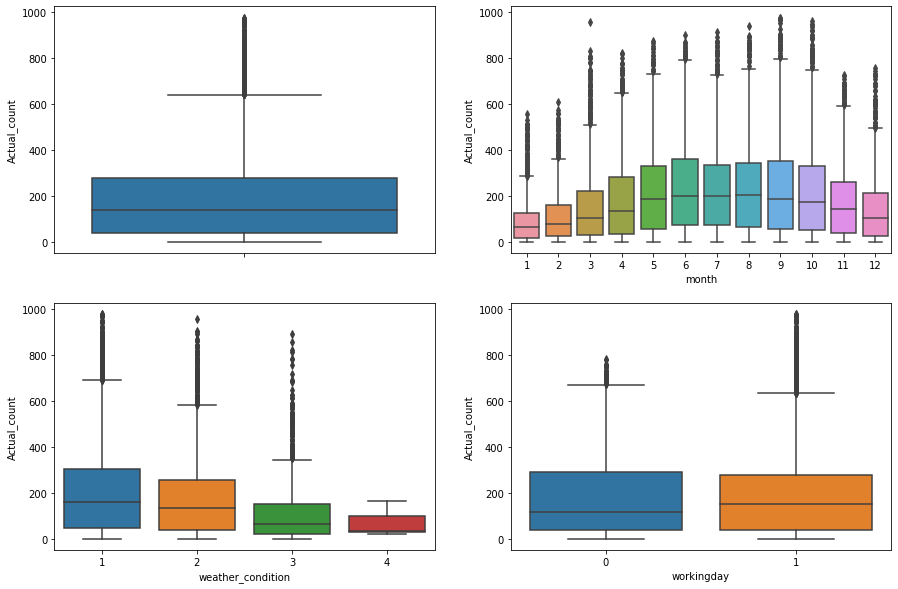

In [9]:
#Visualising parameters using boxplot to check outliers
fig,ax = plt.subplots(ncols=2, nrows= 2, figsize = (15,10))
#fig.set_size_inches(15,15)
sns.boxplot(data=rental_hour_raw, y = 'Actual_count',ax=ax[0][0])
sns.boxplot(data=rental_hour_raw, x = 'month', y = 'Actual_count',ax=ax[0][1])
sns.boxplot(data=rental_hour_raw, x = 'weather_condition', y = 'Actual_count', ax=ax[1][0])
sns.boxplot(data=rental_hour_raw, x = 'workingday', y = 'Actual_count',ax=ax[1][1])

[Text(0.5, 1.0, 'Checking for outliners in day hours')]

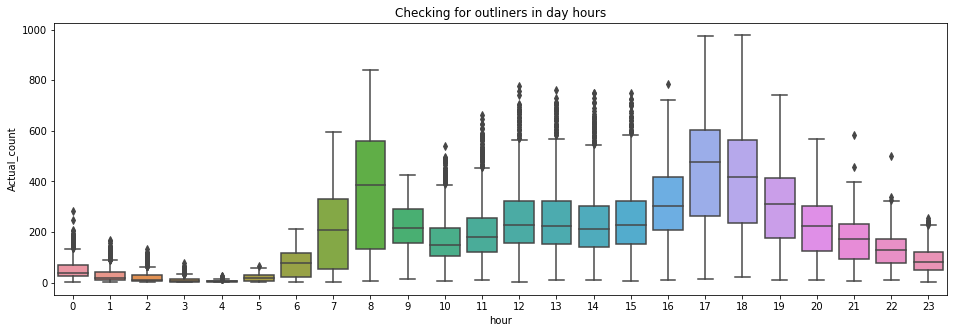

In [11]:
fig,ax = plt.subplots(figsize = (16,5))
sns.boxplot(data=rental_hour_raw[['Actual_count',
                          'hour']],x='hour',y='Actual_count',ax=ax)
ax.set(title="Checking for outliners in day hours")

Here initially we consider the distribution plot of all the rental counts, where these values are compared with its corresponding distribution.

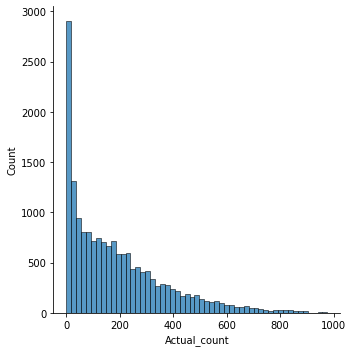

In [12]:
#Checking the distribution of bike rental count to remove outliers
sns.displot(rental_hour_raw.Actual_count)

Interquartile range method to remove outliers requires the following steps:



*   Sort the data from low to high
*   Identify the first quartile (Q1) and the third quartile (Q3).

*   Calculate IQR = Q3 – Q1

*   Calculate upper fence = Q3 + (1.5 * IQR)
*   Calculate lower fence = Q1 – (1.5 * IQR)


*   Use your fences to highlight any outliers, all values that fall outside your fences.










Samples in original Dataset with outliers:  17379
Samples in original dataset after outliers are removed:  16874


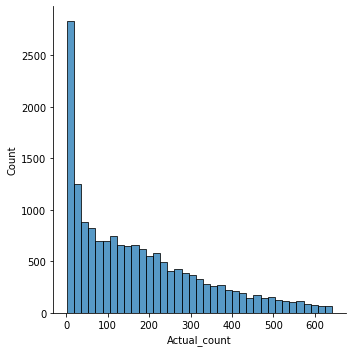

In [13]:
print("Samples in original Dataset with outliers: ", len(rental_hour_raw))
q1 = rental_hour_raw.Actual_count.quantile(0.25)
q3 = rental_hour_raw.Actual_count.quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - (1.5 * iqr)
upper_fence = q3 + (1.5 * iqr)
rental_hour = rental_hour_raw.loc[(rental_hour_raw.Actual_count >= lower_fence) & (rental_hour_raw.Actual_count <= upper_fence)]
print('Samples in original dataset after outliers are removed: ', len(rental_hour))
sns.displot(rental_hour.Actual_count)

In [14]:
# resetting index to counter the drooped rows
rental_hour.reset_index(drop = True, inplace = True)

# **Section II**
Exploratory Data Analysis

## Pearson Correlation coefficient

Correlation method is performed to check for releationship between two variables. The correlation ranges between -1 and 1. A values of near or equal to 0 implies little or no releationship between them and a value closer to 1 or -1 imples the stronger linear releationship. It is calcualated as the ratio between the covariance of two variables and the product of their standard deviations. 

Why should highly correlated variables be removed?

If two variables are so highly correlated they will obviously impart nearly exactly the same information to regression model. But, by including both they are actually weakening the model. They are not adding incremental information. Instead, they are infusing the model with noise.

We can see that on the target variable line the most correlated variables to the count are :


*   the temperature

*   the normalized temperature
*   the humidity


*   the windspeed

**We can see that there is a multi correlation between columns 'Temperature' and 'norm_temperature' so we can drop any of the column say 'norm_temperature' and they have the same variations.**

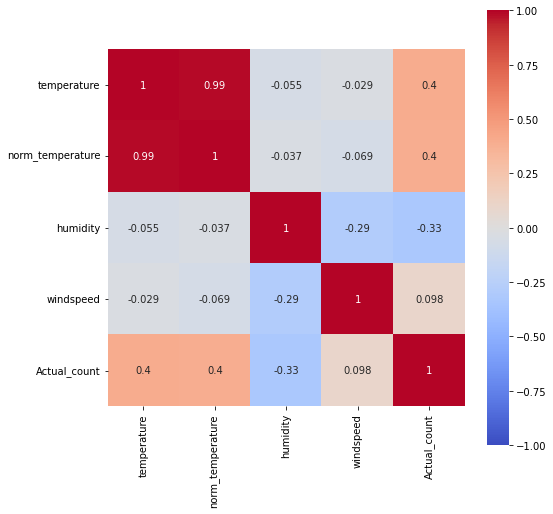

In [15]:
# Checking correlation between variables using heat map
plt.figure(figsize= (8,8))
sns.heatmap(rental_hour.iloc[:, 9:].corr('pearson'), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True, square = True)

In [16]:
#Dropping norm_temperature column
rental_hour.drop(labels = 'norm_temperature', axis = 1, inplace = True)

#Final Correlation with the target variable
df1Corr=pd.DataFrame(rental_hour.iloc[:,9:].corr().unstack().sort_values(ascending=False)['Actual_count'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("coral", as_cmap=True))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Correlation to the target
Actual_count,1.000000
temperature,0.401579
windspeed,0.097801
humidity,-0.326973


## Data Exploration

As the data has been cleaned, the data is now ready to be used for analysis. But before that, it is imperative to understand the data before performing modelling. EDA is the crucial process of using summary statistics and graphical representations to perform preliminary investigations on data in order to uncover patterns, detect anomalies, test hypotheses, and verify assumptions.

### Analysis 1




***In this first plot, we see a high rise in bike rental during the months from April through August.***

Text(0, 0.5, 'Average rentals')

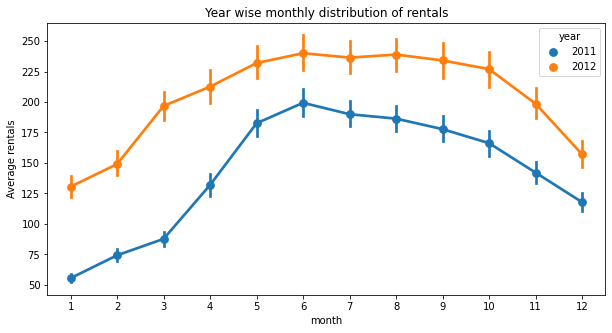

In [17]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=rental_hour[['month',
                           'Actual_count',
                           'year']],
              x='month',
              y='Actual_count',
              hue='year',
              ax=ax)
ax.set(title="Year wise monthly distribution of rentals")
ax.set_ylabel('Average rentals')


***From the second graph, as we expected summer is the season which we made the most rentals.***

***Let's try to understand why summer is the season with the most rentals.***

,Actual_count
season,
3,1061129
2,918589
4,841613
1,471348


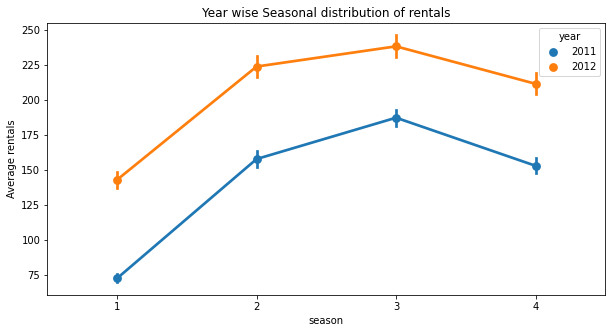

In [18]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.pointplot(data=rental_hour[['season',
                           'Actual_count',
                           'year']],
              x='season',
              y='Actual_count',
              hue='year',
              ax=ax)
ax.set(title="Year wise Seasonal distribution of rentals")
ax.set_ylabel('Average rentals')


renthourVizSeasons=pd.DataFrame(rental_hour_raw.groupby('season').sum()['Actual_count'].sort_values(ascending=False))
renthourVizSeasons.style.background_gradient(cmap=sns.light_palette("coral", as_cmap=True))


*Let's try to understand more about the increase in rentals during the summer season.*

*This plot explains the high correlation with the feature 'temperature' and 'Summer season'*


In [19]:
renthourViztemp=pd.DataFrame(rental_hour.groupby('season').mean()['temperature'].sort_values(ascending=False))
renthourViztemp.style.background_gradient(cmap=sns.light_palette("coral", as_cmap=True))

,temperature
season,
3,0.705207
2,0.541557
4,0.419946
1,0.297651


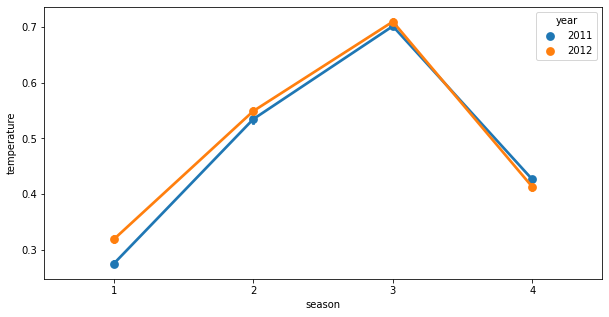

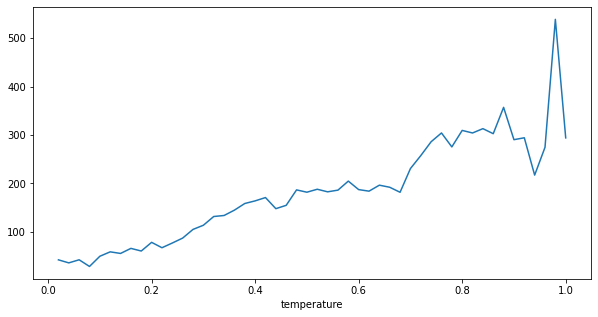

In [20]:
fig,ax = plt.subplots(figsize=(10, 5))
fig,ax1 = plt.subplots(figsize=(10, 5))

sns.pointplot(data=rental_hour[['season',
                           'temperature',
                           'year']],
              x='season',
              y='temperature',
              hue='year',
              ax=ax)

rental_hour.groupby('temperature').mean()['Actual_count'].plot()

*From the first graph, we can observe that the temperature during summer exceeds its yearly average temperature of 0.49 and from the second graph that the bike rentals were increasing with the increase in temperature. We can also notice the count of bikes rented exceeds its average rental count of 189, when the temperature is greater than mean of 0.49*
 
***From these two observations, we can conclude that people prefer to commute in bike rentals service during warm weather conditions.***

### Analysis 2

*Here we have repartitioned rental count based on hour of the day. We could notice that there is spike during 8AM and the same during 5PM - 7PM, post which we can witness the trend towards the end the day. We can assume that people prefer to commute to school or work and return by bike.*

Text(0, 0.5, 'Average rentals')

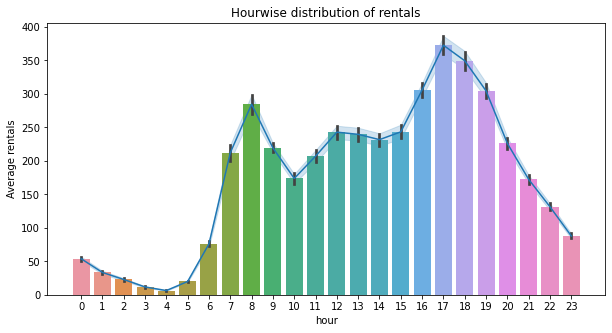

In [21]:
fig,ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=rental_hour[['hour',
                           'Actual_count']],
              x='hour',
              y='Actual_count',
              ax=ax)

sns.lineplot(data=rental_hour[['hour',
                           'Actual_count']],
              x='hour',
              y='Actual_count',
              ax=ax)

ax.set(title="Hourwise distribution of rentals")
ax.set_ylabel('Average rentals')


***To support the assumption we made, we can also observe that the Days with highest rented bike are weekdays and also the average count on vehicles rented on working days were more than the Non working days. So we can conclude people rent bikes to go to work or school.***

Text(0, 0.5, 'Average rentals')

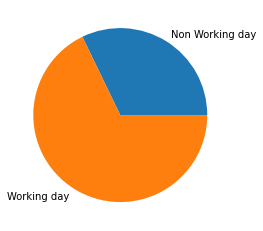

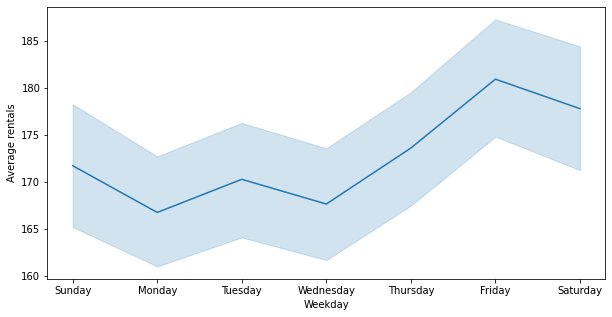

In [22]:
y = rental_hour.groupby('workingday').sum()['Actual_count']
plt.pie(y, labels = ['Non Working day', 'Working day'])





fig,ax = plt.subplots(figsize=(10, 5))
plot = sns.lineplot(data=rental_hour[['weekday',
                           'Actual_count']],
              x='weekday',
              y='Actual_count',
              ax=ax)
plot.set_xticklabels(['Days','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plot.set_xlabel('Weekday')
plot.set_ylabel('Average rentals')

#**Section III**
Model selection and building

## Model 1: Linear Regression

### Model Building

Linear Regression has 2 methods to solve the cost function

1)Normal Equation

2)Gradient Descent

**NORMAL EQUATION**

The normal equation is a closed-form solution used to find the value of θ that minimizes the cost function. Another way to describe the normal equation is as a one-step algorithm used to analytically find the coefficients that minimize the loss function.


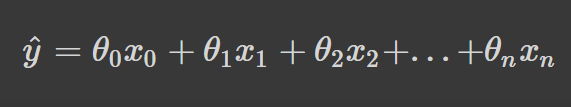


Where θ represents the parameters and n is the number of features.

Essentially, all that occurs in the above equation is the dot product of θ, and x is being summed. Thus, a more concise way to represent this is to use its vectorized form:
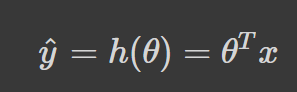

h(θ) is the hypothesis function.

Given this approximate target function, we can use our model to make predictions. To determine if our model has learned well, it’s important we measure the performance of our model on the training data. For this purpose, we compute a loss function. The goal of the training process is to find the values of theta (θ) that minimize the loss function.

Here’s how we can represent our loss function mathematically:

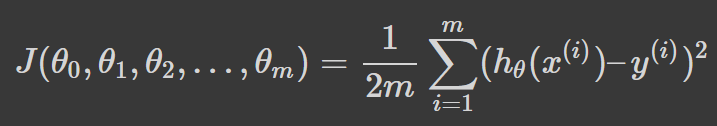

In the above equation, theta (θ) is a n + 1 dimensional vector, and our loss function is a function of the vector value. Consequently, the partial derivative of the loss function, J, has to be taken with respect to every parameter of θ_j in turn. All of them must equal zero. Following this process and solving for all of the values of θ from θ_0 to θ_n will result in the values of θ that minimize the loss function.

Working through the solution to the parameters θ_0 to θ_n using the process described above results in an extremely involved derivation procedure. There is indeed a faster solution.

Take a look at the formula for the normal equation:


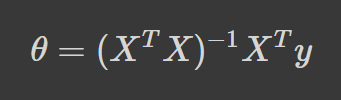

Where:

θ → The parameters that minimize the loss function X → The input feature values for each instance y → The vector of output values for each instance

**GRADIENT DESCENT**

Gradient Descent is an algorithm that finds the best-fit line for a given training dataset in a smaller number of iterations.

If we plot m and c against MSE, it will acquire a bowl shape (As shown in the diagram below)

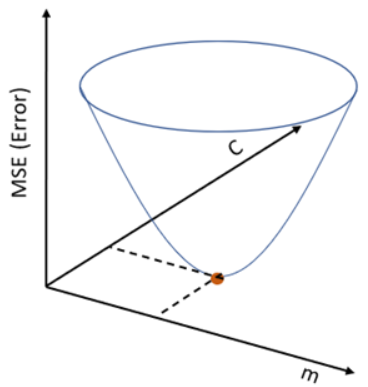

Step by Step Algorithm:

1.Let m = 0 and c = 0. Let L be our learning rate. It could be a small value like 0.01 for good accuracy.

Learning rate gives the rate of speed where the gradient moves during gradient descent. Setting it too high would make your path instable, too low would make convergence slow. Put it to zero means your model isn’t learning anything from the gradients.

 

2.Calculate the partial derivative of the Cost function with respect to m. Let partial derivative of the Cost function with respect to m be Dm (With little change in m how much Cost function changes).


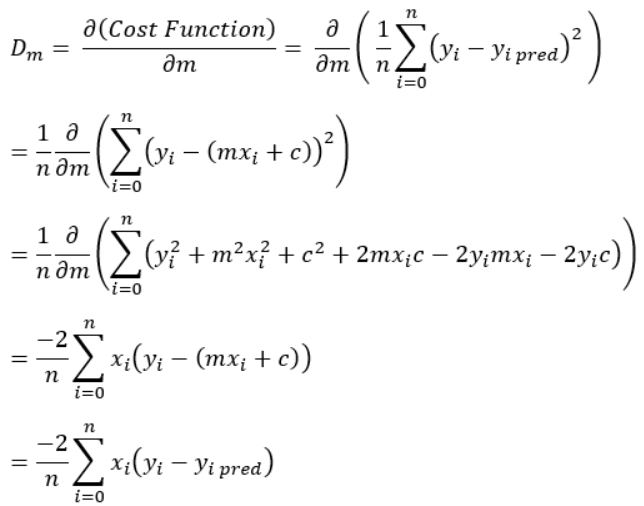

Similarly, let’s find the partial derivative with respect to c. Let partial derivative of the Cost function with respect to c be Dc (With little change in c how much Cost function changes).

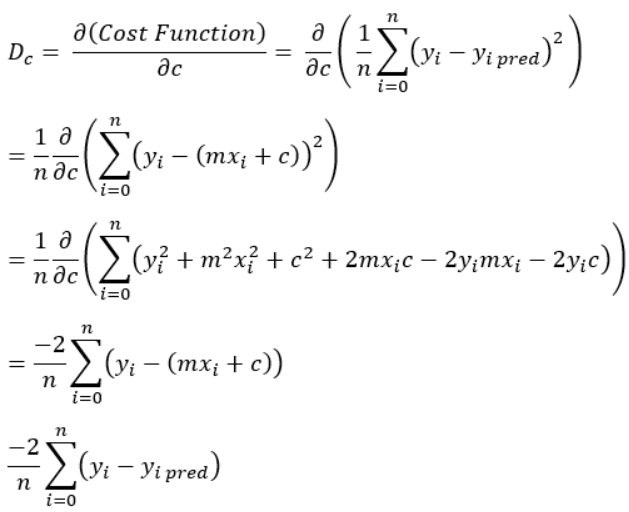

3.Now update the current values of m and c using the following equation:

**m=m-LDm**

**c=c-LDc**

4.We will repeat this process until our Cost function is very small (ideally 0).


**REGULARIZATION**

One of the major aspects of training your machine learning model is avoiding overfitting. The model will have a low accuracy if it is overfitting. This happens because your model is trying too hard to capture the noise in your training dataset. By noise we mean the data points that don’t really represent the true properties of your data, but random chance. Learning such data points, makes your model more flexible, at the risk of overfitting.


This is a form of regression, that constrains/ regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.


**RIDGE REGRESSION**

The cost function for ridge regression is as follows

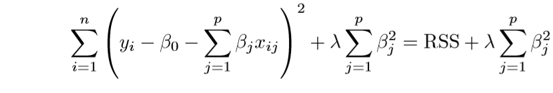

**LASSO**

The cost function for lasso regression is as follows

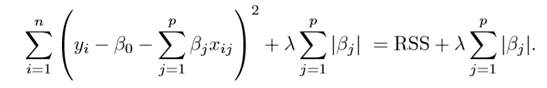


In order to optimize the model picking up an optimal hyperparameter i.e lambda is very crucial.

There are many ways to find an optimal hyperparameter.
one such approach is k cross validation and we've implemented the same in this project.

**K CROSS VALIDATION**

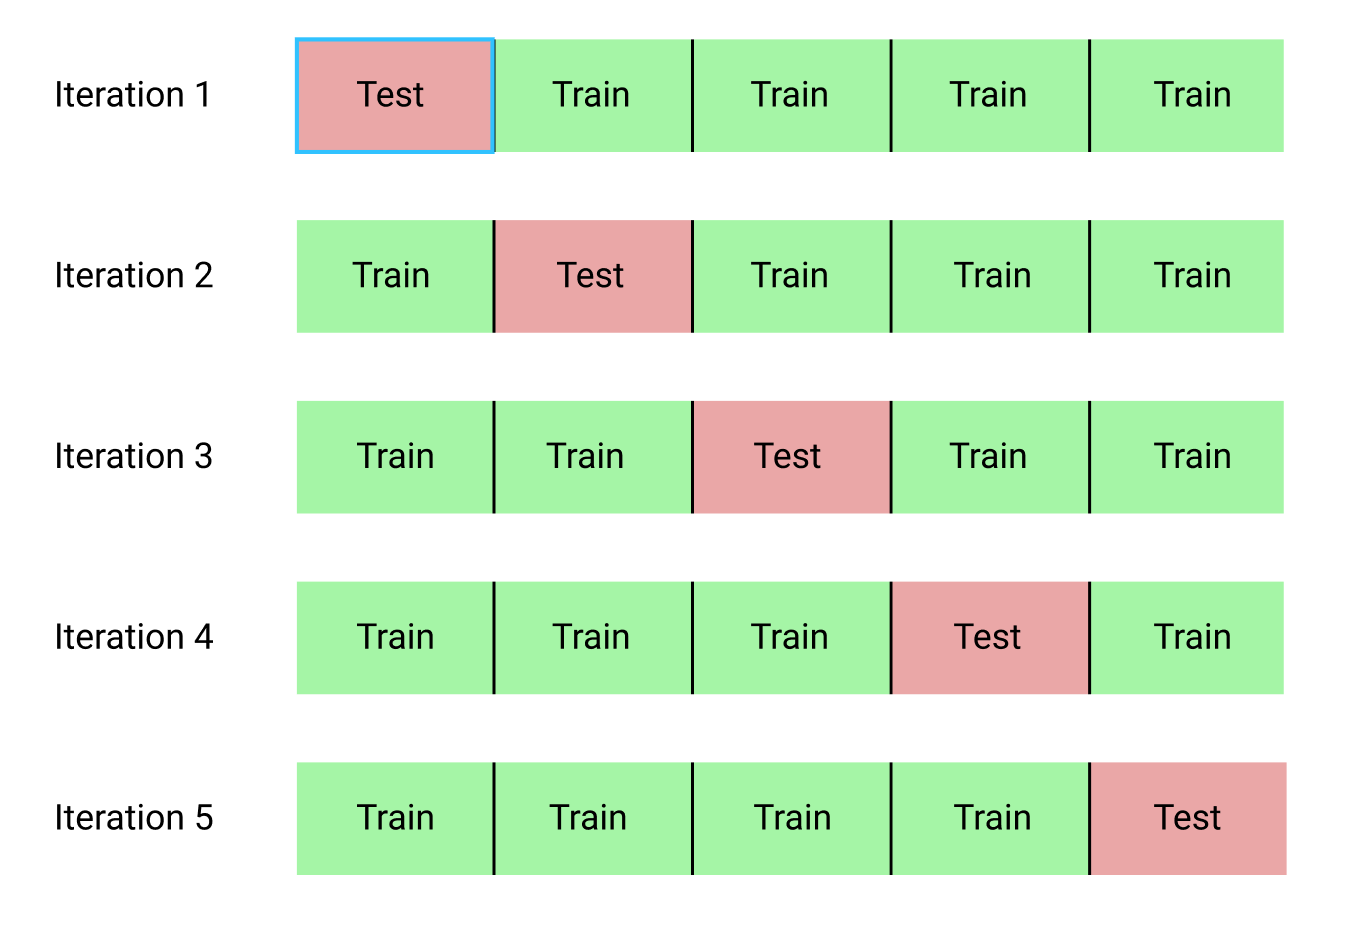

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

If k=5 the dataset will be divided into 5 equal parts and the below process will run 5 times, each time with a different holdout set.

1.Take the group as a holdout or test data set

2.Take the remaining groups as a training data set

3.Fit a model on the training set and evaluate it on the test set

4.Retain the evaluation score and discard the model

At the end of the above process Summarize the skill of the model using the sample of model evaluation scores.

A value of k=10 is very common in the field of applied machine learning, and is recommend if you are struggling to choose a value for your dataset.

In [45]:
class Linear_Regression:
  def __init__(self,X,y,minMax,reg,gradient,folds,learningRate,
               tolerance,
               maxIteration,lasso,ridge,)->None:
    self.X=X
    self.y=y
    self.minMax=minMax
    self.reg=reg
    self.gradient=gradient
    self.folds=folds
    self.learningRate=learningRate
    self.tolerance=tolerance
    self.maxIteration=maxIteration
    self.lasso=lasso
    self.ridge=ridge

#splitting data intoi test train and valid sets
  def splittingData(self,X,y):
    train_size = (int)(0.7 * X.shape[0])
    self.X_train = X[0:train_size]
    self.X_test = X[train_size:]
    self.y_train = y[0:train_size]
    self.y_test = y[train_size:]
    # print("X train:",self.X_train.shape)
    # print("X test:",self.X_test.shape)
    # print("y train:",self.y_train.shape)
    # print("y test:",self.y_test.shape)
    # self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(self.X,self.y,train_size=0.7,shuffle=False,random_state=42)

#Split Fucntion for K cross validation
  def kCrossSplit(self,X,y,bins,k,binSize):
    i=1
    prevSize=0
    X_test=np.empty([binSize,X.shape[1]],dtype=int)
    X_train=np.empty([X.shape[0]-binSize,X.shape[1]],dtype=int)
    y_test=np.empty([binSize],dtype=int)
    y_train=np.empty([y.shape[0]-binSize],dtype=int)
    for size in bins:
      if i==k:
        X_test=X[prevSize:size,]
        y_test=y[prevSize:size]
        prevSize=size
      else:
        X_train=np.concatenate((X_train,X[prevSize:size,:]))
        y_train=np.concatenate((y_train,y[prevSize:size]))
        prevSize=size
      i=i+1
      return X_train,X_test,y_train,y_test
      

      
#adding bias 
  def add_X0(self,X):
    return np.column_stack([np.ones(X.shape[0]),X])
 
#scaling data using minmax scaler
  def normalizeData(self,X):
    #print("normalizing train data")
    max=np.amax(X)
    min=np.amin(X)
    X_scaled=(X-min)/max-min
    X=self.add_X0(X_scaled)
    #print("train data shape:",X.shape)
    return X,max,min

  def normalizeTestData(self,X,max,min):
    #print("normalizing test data")
    X=(X-min)/max-min
    X=self.add_X0(X)
    #print("test data shape:",X.shape)
    return X

#scaling data using mean and standard deviation
  def standardizeData(self,X):
    mean=np.mean(X,0)
    std=np.std(X,0)
    X_scaled=(X-mean)/std
    X_scaled=self.add_X0(X_scaled)
    return X_scaled,mean,std
  
  def standardizeTestData(self,X,mean,std):
    X_scaled=(X-mean)/std
    X_scaled=self.add_X0(X_scaled)
    return X_scaled

#full rank and low rank checks for data
  def fullRankCheck(self,X):
    rank=np.linalg.matrix_rank(X)
    if(rank==min(X.shape[0],X.shape[1])):
      print("data is full rank")
      self.fullRank=True
    else:
      self.fullRank=False
    return self.fullRank

  def lowRankCheck(self,X):
    if(X.shape[0]>X.shape[1]):
      print("data is low rank")
      self.lowRank=True
    else:
      self.lowRank=False
    return self.lowRank

  def normalEquation(self,X,y):
    self.theta=np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return self.theta

  def normalEquationWL2(self,X,y):
    I=np.identity(X.shape[1],dtype=float)
    self.theta=np.linalg.inv(X.T.dot(X)+self.lamda*I).dot(X.T).dot(y)
    return self.theta

  def predict(self,X):
    return X.dot(self.theta)
  
  #def predict2(self,X):
    #return X.dot(self.theta[1:])+self.theta[0]
    
  def sse(self,X,y):
    y_hat=self.predict(X)
    sse = ((y_hat-y)**2).sum()
    return sse

    
  def RMSE(self,X,y):
    N = X.shape[0]
    sse = self.sse(X,y)
    RMSE = np.sqrt(sse/N)
    return RMSE

  def regSummary(self,X,y):
    pred_y=self.predict(X)
    regressionSummary(pred_y,y)
    return pred_y

  def costFunction(self,X,y):
    return self.sse(X,y)/2

  def costDerivative(self,X,y):
    y_hat= self.predict(X)
    return (y_hat - y).dot(X)
  
  def costderiviationL1(self,X,y):
    f = self.costDerivative(X,y)
    f += (self.lamda)*np.linalg.norm(self.theta)
    return f       

  def costderiviationL2(self, X,y):
      f = self.costDerivative(X,y)
      f += (self.lamda)*self.theta
      return f  

  def gradientThetaCalculation(self,X,y):
    if (self.lasso):
      return self.theta-self.learningRate*self.costderiviationL1(X,y)
    elif(self.ridge):
      return self.theta-self.learningRate*self.costderiviationL2(X,y)
    else:
      return self.theta-self.learningRate*self.costDerivative(X,y)
 
  def gradientSolution(self,X,y):
    #we initialise randommtheta values in fit functn
    #so that it doiesnt get initialised eveyrtime we call this fntn
    errors=[]
    last_error=float('inf')
    for i in tqdm(range(self.maxIteration)):
      self.theta=self.gradientThetaCalculation(X,y)
      #self.theta-self.learningRate*self.costDerivative(X,y)
      current_error=self.RMSE(X,y)
      diff=last_error-current_error
      errors.append(current_error)
      last_error=current_error
      if(diff<self.tolerance):
        print("model stopped learning")
        break
    #self.plot_rmse(errors)

  
  def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        #ax.set(xlabel='iterations', ylabel=self.error,
              # title='{} trend'.format(self.error))
        #ax.grid()

        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()   
   

  def fit(self):
    optimal_lamda=0
    self.splittingData(self.X,self.y)
    if(self.minMax):
      self.X_train,max,min=self.normalizeData(self.X_train)
      self.X_test=self.normalizeTestData(self.X_test,max,min)
    else:
      self.X_train,mean,std=self.standardizeData(self.X_train)
      self.X_test=self.standardizeTestData(self.X_test,mean,std)
      self.fullRankCheck(self.X_train)
      self.lowRankCheck(self.X_train)

    if(self.fullRankCheck and self.lowRankCheck):
      if(self.reg and not self.gradient):
        print("executing normalEquation with regulariation")
        #resplitting data for k-cross validation
        #A series of Lambda values with a step of 0.1 from 0.1 to 25
        lambda_list=np.arange(0.1,10.1,0.1)
        self.X_train,self.y_train=shuffle(self.X_train,self.y_train,random_state=0)
        binSize=int(np.round(self.X_train.shape[0]/self.folds))
        bins=np.arange(binSize,self.X_train.shape[0],
                      binSize)
        lambda_avg_list=[]
        for i in lambda_list:
          self.lamda=i
          #print("lambda value:",i)
          #print("----------------------------------------")
          k_lambda_costs=[]
          for k in range(1,self.folds+1):
            X_train,X_test,y_train,y_test=self.kCrossSplit(self.X_train,self.y_train,bins,k,binSize)
            self.theta=self.normalEquationWL2(X_train,y_train)
            k_lambda_costs.append(self.sse(X_test,y_test))
          k_lambda_avg=np.average(k_lambda_costs)
          #print("lamda_costs:",k_lambda_costs)
          #print("lambda_size:",len(k_lambda_costs))
          #print("lambda and it's avg",i,k_lambda_avg)
          lambda_avg_dict={"lamda":i,"k_lambda_avg":k_lambda_avg}
          lambda_avg_list.append(lambda_avg_dict)
          df_lambda_avg=pd.DataFrame(lambda_avg_list)
        #print(df_lambda_avg.head())
        df_lambda_avg=df_lambda_avg.sort_values('k_lambda_avg',ascending=True)
        #print(df_lambda_avg.head())
        optimal_lambda=df_lambda_avg.iloc[0,0]
        print("optimal_lambda",optimal_lambda)
        self.lamda=optimal_lambda
        self.theta=self.normalEquationWL2(self.X_train,self.y_train)
        total_loss=self.sse(self.X_test,self.y_test)
        #print("total loss:",total_loss)
        print("Train data Results")
        pred=self.regSummary(self.X_train,self.y_train)
        print("--------------------------------------")
        print("Test data Results") 
        preds=self.regSummary(self.X_test,self.y_test)
        print("----------------------------------------")
      elif(not self.reg and not self.gradient):
        print("nomral equation")
        self.theta=self.normalEquation(self.X_train,self.y_train)
        #print(self.theta)
        #print("total loss:",self.sse(self.X_test,self.y_test))
        print("Train data Results")
        pred=self.regSummary(self.X_train,self.y_train)
        print("--------------------------------------")
        print("Test data Results") 
        preds=self.regSummary(self.X_test,self.y_test)
      elif (not self.reg and self.gradient and not self.lasso and not self.ridge):
        print("executing gradient descent")
        self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0
        self.gradientSolution(self.X_train,self.y_train)
        #print("total loss:",self.sse(self.X_test,self.y_test))
        print("Train data")
        pred=self.regSummary(self.X_train,self.y_train)
        print("--------------------------------------")
        print("Test data") 
        preds=self.regSummary(self.X_test,self.y_test)
      elif (self.reg and self.gradient and self.lasso):
        print("executing gradient descent with lasso")
        self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0

        #resplitting data for k-cross validation
        #A series of Lambda values with a step of 0.1 from 0.1 to 25
        lambda_list=np.arange(0.1,10.1,0.1)
        self.X_train,self.y_train=shuffle(self.X_train,self.y_train,random_state=0)
        binSize=int(np.round(self.X_train.shape[0]/self.folds))
        bins=np.arange(binSize,self.X_train.shape[0],
                      binSize)
        lambda_avg_list=[]
        for i in lambda_list:
          self.lamda=i
          #print("lambda value:",i)
          #print("----------------------------------------")
          k_lambda_costs=[]
          for k in range(1,self.folds+1):
            X_train,X_test,y_train,y_test=self.kCrossSplit(self.X_train,self.y_train,bins,k,binSize)
            self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0
            self.gradientSolution(X_train,y_train)
            k_lambda_costs.append(self.sse(X_test,y_test))
          k_lambda_avg=np.average(k_lambda_costs)
          #print("lamda_costs:",k_lambda_costs)
          #print("lambda_size:",len(k_lambda_costs))
          #print("lambda and it's avg",i,k_lambda_avg)
          lambda_avg_dict={"lamda":i,"k_lambda_avg":k_lambda_avg}
          lambda_avg_list.append(lambda_avg_dict)
          df_lambda_avg=pd.DataFrame(lambda_avg_list)
        #print(df_lambda_avg.head())
        df_lambda_avg=df_lambda_avg.sort_values('k_lambda_avg',ascending=True)
        #print(df_lambda_avg.head())
        optimal_lambda=df_lambda_avg.iloc[0,0]
        print("optimal_lambda",optimal_lambda)
        self.lamda=optimal_lambda
        
        self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0
        self.gradientSolution(self.X_train,self.y_train)
        #print("total loss:",self.sse(self.X_test,self.y_test))
        print("Train data")
        pred=self.regSummary(self.X_train,self.y_train)
        print("--------------------------------------")
        print("Test data")
        preds=self.regSummary(self.X_test,self.y_test)
      elif (self.reg and self.gradient and self.ridge):
        print("executing gradient descent with ridge")
        self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0

        #resplitting data for k-cross validation
        #A series of Lambda values with a step of 0.1 from 0.1 to 25
        lambda_list=np.arange(0.1,10.1,0.1)
        self.X_train,self.y_train=shuffle(self.X_train,self.y_train,random_state=0)
        print("x train:",self.X_train[0:3,0:3])
        binSize=int(np.round(self.X_train.shape[0]/self.folds))
        bins=np.arange(binSize,self.X_train.shape[0],
                      binSize)
        lambda_avg_list=[]
        for i in lambda_list:
          self.lamda=i
          #print("lambda value:",i)
          #print("----------------------------------------")
          k_lambda_costs=[]
          for k in range(1,self.folds+1):
            X_train,X_test,y_train,y_test=self.kCrossSplit(self.X_train,self.y_train,bins,k,binSize)
            self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0
            self.gradientSolution(X_train,y_train)
            k_lambda_costs.append(self.sse(X_test,y_test))
          k_lambda_avg=np.average(k_lambda_costs)
          #print("lamda_costs:",k_lambda_costs)
          #print("lambda_size:",len(k_lambda_costs))
          #print("lambda and it's avg",i,k_lambda_avg)
          lambda_avg_dict={"lamda":i,"k_lambda_avg":k_lambda_avg}
          lambda_avg_list.append(lambda_avg_dict)
          df_lambda_avg=pd.DataFrame(lambda_avg_list)
        #print(df_lambda_avg.head())
        df_lambda_avg=df_lambda_avg.sort_values(['lamda','k_lambda_avg'],ascending=True)
        #print(df_lambda_avg.head())
        optimal_lambda=df_lambda_avg.iloc[0,0]
        print("optimal_lambda",optimal_lambda)
        self.lamda=optimal_lambda
        
        self.theta=np.ones(self.X_train.shape[1],dtype=np.float16)*0
        self.gradientSolution(self.X_train,self.y_train)
        #print("total loss:",self.sse(self.X_test,self.y_test))
        print("Train data")
        pred=self.regSummary(self.X_train,self.y_train)
        print("--------------------------------------")
        print("Test data")
        preds=self.regSummary(self.X_test,self.y_test)
      values={"Predicted_count":np.round(preds),"Actual_count":self.y_test}
      result=pd.DataFrame(values)
      return result,self.theta

### Model Fitting and Prediction

Normal Equation

nomral equation
Train data Results

Regression statistics

                      Mean Error (ME) : 0.1704
       Root Mean Squared Error (RMSE) : 112.6555
            Mean Absolute Error (MAE) : 85.0644
          Mean Percentage Error (MPE) : 9.6476
Mean Absolute Percentage Error (MAPE) : 89.9705
--------------------------------------
Test data Results

Regression statistics

                      Mean Error (ME) : 24.0888
       Root Mean Squared Error (RMSE) : 141.3647
            Mean Absolute Error (MAE) : 117.5753
          Mean Percentage Error (MPE) : 16.5796
Mean Absolute Percentage Error (MAPE) : 53.7719


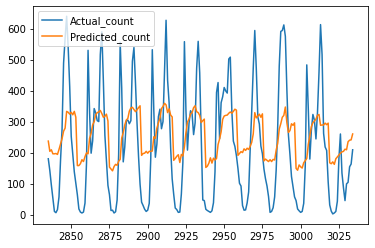

In [46]:
nm=Linear_Regression(rental_hour.values[:,0:-1],rental_hour.values[:,-1],
                    minMax=True,
                    reg=False,
                    gradient=False,
                    maxIteration=25000,
                    tolerance=0.005,
                    learningRate=0.00001,
                    lasso=False,
                    ridge=False,
                    folds=10)
result,theta=nm.fit()
result.iloc[2835:3035][['Actual_count','Predicted_count']].plot()

Normal Equation with Regularization

In [47]:
nm=Linear_Regression(rental_hour.values[:,0:-1],rental_hour.values[:,-1],
                    minMax=True,
                    reg=True,
                    gradient=False,
                    folds=10,
                    maxIteration=25000,
                    tolerance=0.000005,
                    learningRate=0.0001,
                    lasso=False,
                    ridge=False)
result,theta=nm.fit()

executing normalEquation with regulariation
optimal_lambda 5.0
Train data Results

Regression statistics

                      Mean Error (ME) : -0.0306
       Root Mean Squared Error (RMSE) : 141.3681
            Mean Absolute Error (MAE) : 113.0350
          Mean Percentage Error (MPE) : -0.0188
Mean Absolute Percentage Error (MAPE) : 74.0757
--------------------------------------
Test data Results

Regression statistics

                      Mean Error (ME) : -66.9456
       Root Mean Squared Error (RMSE) : 186.5744
            Mean Absolute Error (MAE) : 149.8231
          Mean Percentage Error (MPE) : -43.8634
Mean Absolute Percentage Error (MAPE) : 98.1654
----------------------------------------


Gradient Descent

In [48]:
nm=Linear_Regression(rental_hour.values[:,0:-1],rental_hour.values[:,-1],
                    minMax=True,
                    reg=False,
                    gradient=True,
                    folds=10,
                    learningRate= 0.00001, 
                    tolerance= 0.00005,
                    maxIteration= 100000,
                    lasso=False,
                    ridge=False)
result,theta=nm.fit()

executing gradient descent


  0%|          | 25/100000 [00:00<00:44, 2260.15it/s]

model stopped learning
Train data

Regression statistics

                      Mean Error (ME) : -0.1370
       Root Mean Squared Error (RMSE) : 141.3683
            Mean Absolute Error (MAE) : 113.0154
          Mean Percentage Error (MPE) : -0.0887
Mean Absolute Percentage Error (MAPE) : 74.1146
--------------------------------------
Test data

Regression statistics

                      Mean Error (ME) : -67.0535
       Root Mean Squared Error (RMSE) : 186.6132
            Mean Absolute Error (MAE) : 149.8423
          Mean Percentage Error (MPE) : -43.9652
Mean Absolute Percentage Error (MAPE) : 98.2474


Gradient Descent with Lasso Regularization

In [ ]:
nm=Linear_Regression(rental_hour.values[:,0:-1],rental_hour.values[:,-1],
                    minMax=True,
                    reg=True,
                    gradient=True,
                    folds=10,
                    learningRate= 0.00001, 
                    tolerance= 0.00005,
                    maxIteration= 50000,
                    lasso=True,
                    ridge=False)
result,theta=nm.fit()

Train data
Regression statistics

                          Mean Error (ME) : -0.1379
           Root Mean Squared Error (RMSE) : 141.3683
                Mean Absolute Error (MAE) : 113.0153
              Mean Percentage Error (MPE) : -0.0893
    Mean Absolute Percentage Error (MAPE) : 74.1149
Test data 
Regression statistics


                          Mean Error (ME) : -67.0544
           Root Mean Squared Error (RMSE) : 186.6135
                Mean Absolute Error (MAE) : 149.8424
              Mean Percentage Error (MPE) : -43.9661
    Mean Absolute Percentage Error (MAPE) : 98.2481

Gradient Descent with Ridge Regularization

In [ ]:
nm=Linear_Regression(rental_hour.values[:,0:-1],rental_hour.values[:,-1],
                    minMax=True,
                    reg=True,
                    gradient=True,
                    folds=10,
                    learningRate= 0.00001, 
                    tolerance= 0.00005,
                    maxIteration= 50000,
                    lasso=False,
                    ridge=True
                    )
result,theta=nm.fit()

Train data
Regression statistics

                          Mean Error (ME) : -0.1376
           Root Mean Squared Error (RMSE) : 141.3683
                Mean Absolute Error (MAE) : 113.0153
              Mean Percentage Error (MPE) : -0.0891
    Mean Absolute Percentage Error (MAPE) : 74.1148


Test data
Regression statistics

                          Mean Error (ME) : -67.0542
           Root Mean Squared Error (RMSE) : 186.6134
                Mean Absolute Error (MAE) : 149.8424
              Mean Percentage Error (MPE) : -43.9658
    Mean Absolute Percentage Error (MAPE) : 98.2479

## **Model 2: Random Forest**

Random forest algorithm is basically a set of muliptle Decison tress working together.

The original dataset is divided into multiple subsets.

Each of these multiple subsets have same no.of rows as the original datset.

Inorder to achieve the above mentioned point. We random sample with replacement. Which means after picking a datapoint,we're putting it back.

This process of creating a series of datasets is called boostrapping.

With the bootstrapped datasets we run the decision tress independently.

Now not all features are used in each if the decison trees that we run.We randomly select few features in each of the bootstrapped datasetsets and train the trees.

For prediction we pass the new datapoint to each decision tree and go with the majority.

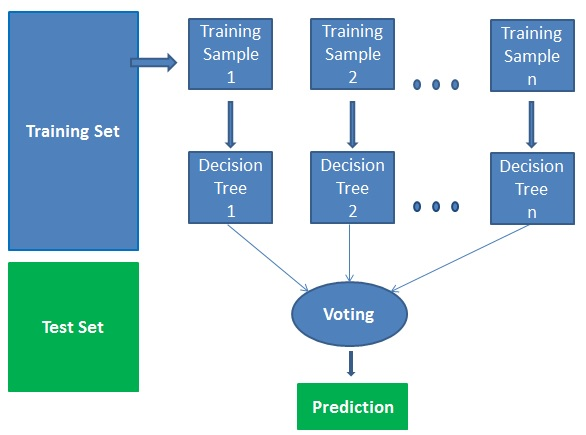

Some of the important parameters that random forest algorithm employs are highlighted below:

n_estimators — the number of decision trees you will be running in the model

criterion — this variable allows you to select the criterion (loss function) used to determine model outcomes. We can select from loss functions such as mean squared error (MSE) and mean absolute error (MAE). The default value is MSE.

max_depth — this sets the maximum possible depth of each tree.

max_features — the maximum number of features the model will consider when determining a split.

max_samples — This parameter assumes bootstrapping is set to True, if not, this parameter doesn’t apply. In the case of True, this value sets the largest size of each sample for each tree.

### Model Building

In [23]:
class tree_regressor_helper:
    
    def __init__(self, max_depth = None, mode=None, n_features=None, criteria='std', seed=None):
        self.tree = self.tree_split()
        self.data_cols = None
        self.max_depth = max_depth
        self.current_depth = 0
        self.criteria = criteria
        self.mode = mode
        self.n_features = n_features
        if seed:
            self._seed = seed
            np.random.seed = seed

    class tree_split:
        def __init__(self,col=-1,value=None,results=None,label=None,tb=None,fb=None, filt=None):
            self.col=col 
            self.value=value 
            self.results=results 
            self.tb=tb 
            self.fb=fb 
            self.filt=filt 
    
    def get_mean_target_value(self, data):
        return np.mean(data)
    
    def split_data(self, X, y, colnum, value):
        splitter = None
        if isinstance(value, int) or isinstance(value,float):
            splitter = lambda x: x[colnum] >= value
        else:
            splitter = lambda x: x[colnum] == value
        split1 = [i for i,row in enumerate(X) if splitter(row)]
        split2 = [i for i,row in enumerate(X) if not splitter(row)]
        set1X = X[split1]
        set1Y = y[split1]
        set2X = X[split2]
        set2Y = y[split2]
        return set1X, set1Y, set2X, set2Y

    def split_criteria(self, y):
        if self.criteria == 'mae':
            mu = np.mean(y)
            return np.mean(np.abs(y-mu))
        else:
            return np.std(y) 
        
    def find_number_of_columns(self, X):
        if isinstance(self.n_features, int):
            return self.n_features
        if self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1])+0.5)
        if self.n_features == 'div3':
            return int(X.shape[1]/3+0.5)
        else:
            raise ValueError("Invalid n_features selection")
    
    def randomize_columns(self,X):
        num_col = self.find_number_of_columns(X)
        filt = np.random.choice(np.arange(0,X.shape[1]),num_col,replace=False)
        filtered_X = self.apply_filter(X, filt)
        return filtered_X, filt
    
    def apply_filter(self, X, filt):
        filtered_X = X.T[filt]
        return filtered_X.T
    
    def pandas_to_numpy(self, x):
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.to_numpy()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def fit(self, X, y):
        self.tree = self._fit(X,y)
    
    def _fit(self, X, y, depth=0):
        X = self.convert_to_array(X)
        y = self.pandas_to_numpy(y)

        if len(X) == 0: return tree_split()
        current_score = self.split_criteria(y)

        best_gain = 0.0
        best_criteria = None
        best_sets = None
        
        self.data_cols = X.shape[1]
        
        if self.mode=='rfnode':
            _, cols = self.randomize_columns(X)
        else: 
            cols = [x for x in range(self.data_cols)]        
        
        
        for col in cols:
            column_values = set(X.T[col])
            for value in column_values:
                set1, set1_y, set2, set2_y = self.split_data(X, y, col, value)
                p = float(len(set1)) / len(y)
                gain = current_score - p*self.split_criteria(set1_y) - (1-p)*self.split_criteria(set2_y)
                if gain > best_gain and len(set1_y) and len(set2_y):
                    best_gain = gain
                    best_criteria = (col, value)
                    best_sets = (np.array(set1), np.array(set1_y), np.array(set2), np.array(set2_y))
        
        if (self.max_depth and depth < self.max_depth) or not self.max_depth:
            if best_gain > 0:
                self.current_depth += 1
                true_branch = self._fit(best_sets[0], best_sets[1], depth=depth+1)
                false_branch = self._fit(best_sets[2], best_sets[3], depth=depth+1)
                return self.tree_split(col=best_criteria[0], value=best_criteria[1],
                        tb=true_branch, fb=false_branch, filt=cols)
            else:
                return self.tree_split(results=self.get_mean_target_value(y))
        else:
            return self.tree_split(results=self.get_mean_target_value(y))

    def print_tree(self, indent="---"):
        self.__original_indent = indent
        self._print_tree_(self.tree, indent)
    
    def _print_tree_(self, tree, indent):
        if tree.results: # if this is a end node
            print(str(tree.results))
        else:
            print('Column ' + str(tree.col)+' : '+str(tree.value)+'? ')
            # Print the branches
            print(indent+' True: ', end=' ')
            next_indent = indent+self.__original_indent
            self._print_tree_(tree.tb,indent=next_indent)
            print(indent+' False: ', end=' ')
            self._print_tree_(tree.fb,indent=next_indent)

    def predict(self, newdata):
        results = []
        newdata = self.convert_to_array(newdata)
        for x in newdata:
            results.append(self._predict(x,self.tree))
        return np.array(results)
            
    def _predict(self, newdata, tree):
        if tree.results is not None: # if this is a end node
            return tree.results

        if isinstance(newdata[tree.col], int) or isinstance(newdata[tree.col],float):
            if newdata[tree.col] >= tree.value:
                return self._predict(newdata, tree.tb)

            else:
                return self._predict(newdata, tree.fb)
        else:
            if newdata[tree.col] == tree.value:
                return self._predict(newdata, tree.tb)
            else:
                return self._predict(newdata, tree.fb) 

    def score(self, X, y):
        X = self.pandas_to_numpy(X)
        y = self.pandas_to_numpy(y)
        pred = self.predict(X)
        return -1. *np.mean((pred-y)**2)

In [24]:
class random_forest_regressor:
    
    def __init__(self, n_trees = 10, max_depth=None, n_features='sqrt', mode='rfnode', seed=None, criteria='std'):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree_filter_pairs = []
        self.mode = mode
        self.criteria = criteria
        if seed:
            self._seed = seed
            np.random.seed(seed)
        
    def find_number_of_columns(self, X):
        if isinstance(self.n_features, int):
            return self.n_features
        if self.n_features == 'sqrt':
            return int(np.sqrt(X.shape[1])+0.5)
        if self.n_features == 'div3':
            return int(X.shape[1]/3+0.5)
        else:
            raise ValueError("Invalid n_features selection")
    
    def get_bagged_data(self, X, y):
        index = np.random.choice(np.arange(len(X)),len(X))
        return X[index], y[index]
    
    def randomize_columns(self,X):
        num_col = self.find_number_of_columns(X)
        filt = np.random.choice(np.arange(0,X.shape[1]),num_col,replace=False)
        filtered_X = self.apply_filter(X, filt)
        return filtered_X, filt
    
    def apply_filter(self, X, filt):
        filtered_X = X.T[filt]
        return filtered_X.T
    
    def pandas_to_numpy(self, x):
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.to_numpy()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 

    def handle_1d_data(self,x):
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    
    def fit(self, X, y):
        X = self.convert_to_array(X)
        y = self.convert_to_array(y)
        try:
            self.base_filt = [x for x in range(X.shape[1])]
        except IndexError:
            self.base_filt = [0]
        for _ in range(self.n_trees):
            filt = self.base_filt
            bagX, bagy = self.get_bagged_data(X,y)
            if self.mode == 'rftree':
                bagX, filt = self.randomize_columns(bagX)
            new_tree = tree_regressor_helper(self.max_depth, mode=self.mode, 
                                               n_features=self.n_features, criteria=self.criteria)
            new_tree.fit(bagX, bagy)
            self.tree_filter_pairs.append((new_tree, filt))
    
    def predict(self, X):
        X = self.convert_to_array(X)
        self.predicts = []
        for tree, filt in self.tree_filter_pairs:
            filtered_X = self.apply_filter(X, filt)
            self.predicts.append(tree.predict(filtered_X))
        self.pred_by_row = np.array(self.predicts).T
        
        ensemble_predict = []
        for row in self.pred_by_row:
            ensemble_predict.append(np.mean(row))
        pred_df = pd.DataFrame(ensemble_predict, columns= ['Predicted_Count'])
        #return ensemble_predict
        return pred_df
    
    def score(self, X, y):
        global pred
        pred = self.predict(X)
        print('RMSE score of Random Forest Model:')
        RMSE = math.sqrt(np.mean((np.array(pred)-np.array(y)) ** 2))
        print(RMSE)
        return RMSE

### Model Fitting and Prediction

Spliting and fitting the train data into the model.

In [25]:
train_size = (int)(0.7 * rental_hour.shape[0])
dfX_train = rental_hour.iloc[0:train_size,0:12]
dfX_test = rental_hour.iloc[train_size:,0:12]
dfy_train = rental_hour.iloc[0:train_size:,12:]
dfy_test = rental_hour.iloc[train_size:,12:]

rf = random_forest_regressor(n_trees=2, n_features='sqrt', mode='rfnode', seed=42)
rf.fit(dfX_train, dfy_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


On Fitting the test data, we can observe from the RMSE value that the accuracy of this model is better than the former model. The difference in the values of Actual and predicted is visualized as graph below for better understanding.

In [26]:
rf.score(dfX_test,dfy_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


RMSE score of Random Forest Model:
107.55942102979434


107.55942102979434

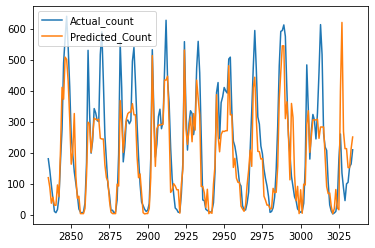

In [27]:
pred['Actual_count'] = dfy_test.values
pred.iloc[2835:3035][['Actual_count','Predicted_Count']].plot()

## **Model 3: ARIMA**

AutoRegressive Integrated Moving Average – ARIMA model is a generalization of a simple autoregressive moving average – ARMA model. Both of these models are used to forecast or predict future points in the time-series data. ARIMA is a form of regression analysis that indicates the strength of a dependent variable relative to other changing variables.

### Why ARIMA

*   The main advantage of ARIMA forecasting is that it only requires data on the time series in
question

*   Forecasting in general is really critical. In practice, ARIMA models occupy the middle-range area of being simple enough to not overfit while being flexible enough to capture some of the patterns hidden in the data






###  ARIMA in Time Series Analysis


The final objective of the model is to predict future time series movement by examining the differences between values in the series instead of using actual values. ARIMA models are applied in the cases where the data shows evidence of non-stationarity. In time series analysis, non-stationary data are always transformed into stationary data.

The common causes of non-stationary in time series data are the trend and the seasonal components. To transform non-stationary data to stationary we apply the differencing step. It is possible to apply the differencing steps more than once to eliminate the trend component in the data.

According to the name, we can split the model into smaller components as follow:

*   AR: an AutoregRegressive model which represents a type of random process. The output of the model is linearly dependent on its own previous value i.e. some number of lagged data points or the number of past observations

*   MA: a Moving Average model which output is dependent linearly on the current and various past observations of a stochastic term

*   I: integrated here means the differencing step to generate stationary time series data, i.e. removing the seasonal and trend components

ARIMA model is generally denoted as ARIMA(p, d, q) and parameter p, d, q are defined as follow:

*   p: the lag order or the number of time lag of autoregressive model AR(p)


*   d: degree of differencing or the number of times the data have had subtracted with past value


*   q: the order of moving average model MA(q)

The Process flows as follows:



1.   Check if data is non-stationary and convert to stationary by differencing.
2.   Predict AR

3.   Predict MA
4.   Combine the results














### Part 1 : Making the data stationary

Before applying any statistical model on a time series, we want to ensure it’s stationary.

What does it mean for data to be stationary?

The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over time.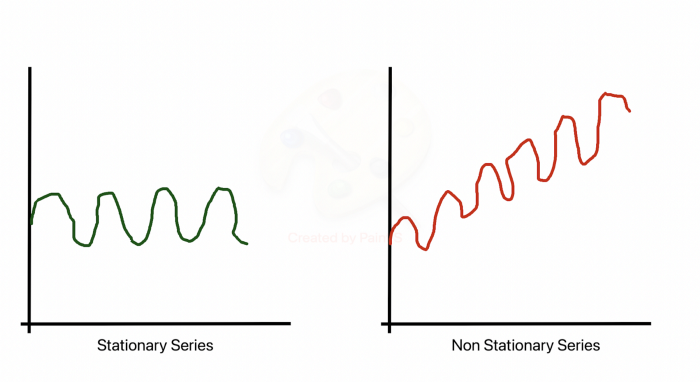


The variance of the series should not be a function of time. This property is known as homoscedasticity. Notice in the red graph the varying spread of data over time.

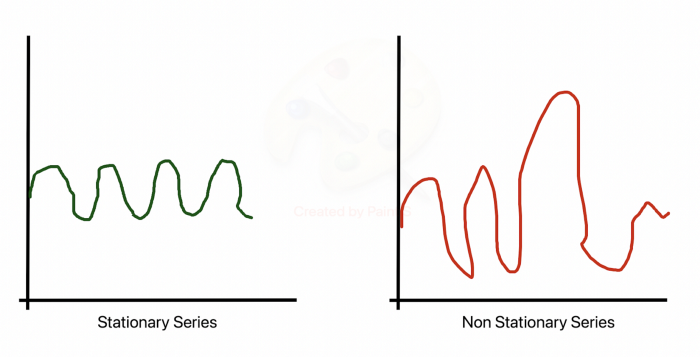

To find if the data is stationary, first the target variable should be converted to log values. This prevents data skewness and to get closer to normal distribution. This way the model is much more suitable for fitting with linear/additive models.

In [28]:
rental_hour_log = rental_hour.copy(deep = True)
rental_hour_log['log_value'] = np.log(rental_hour_log.Actual_count)

In [29]:
rental_hour_log.head()

,datetime,season,year,month,hour,holiday,weekday,workingday,weather_condition,temperature,humidity,windspeed,Actual_count,log_value
0,20110101,1,2011,1,0,0,6,0,1,0.24,0.81,0.0,16,2.772589
1,20110101,1,2011,1,1,0,6,0,1,0.22,0.80,0.0,40,3.688879
2,20110101,1,2011,1,2,0,6,0,1,0.22,0.80,0.0,32,3.465736
3,20110101,1,2011,1,3,0,6,0,1,0.24,0.75,0.0,13,2.564949
4,20110101,1,2011,1,4,0,6,0,1,0.24,0.75,0.0,1,0.000000


From the below chart we can see, the rolling mean and rolling standard deviation doesn't vary much with time. Therefore, we can conclude that the given time series data by default is stationary. Now, since the data is stationary, we don't have to perform differencing. Time series analyis with stationary data by default is called as ARMA instead of ARIMA.

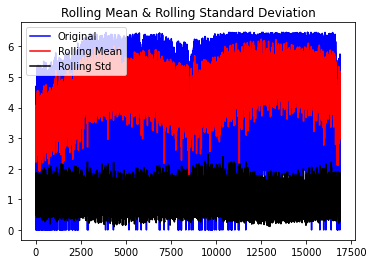

In [30]:
#Method 1 to find if data is stationary
rolling_mean = rental_hour_log['log_value'].rolling(window = 12).mean()
rolling_std = rental_hour_log['log_value'].rolling(window = 12).std()
plt.plot(rental_hour_log['log_value'], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'upper left')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Another method to predict if the data is stationary or not is the Augmented Dickey-Fuller Test. In this Statistical method the time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.

In [31]:
#Method 2 to find if data is stationary
def adfuller_test(value):
  s = []
  result = adfuller(value)
  print('Augmented Dickey-Fuller Test:')
  labels = ['ADF Test Statistic','p-value', '#Lags Used', 'Number of Observations']
  for value, label in zip(result,labels):
    s= label+':'+str(value)
    print(s)
  if result[1] <= 0.05:
    print('Strong evidence against the null hypothesis(H0), Reject the null hypothesis. Data is stationary')
  else:
    print('Weak evidence against null hypothesis, indicating it is non-stationary')

The ADF Statistic is far from the critical values and the p-value is lesser than the threshold (0.05). Thus, we can conclude that the time series is stationary.

In [32]:
#Check for Stationary or not
for name, column in rental_hour_log[['temperature','humidity','windspeed','Actual_count','log_value']].iteritems():
  print('ADF test for',name)
  adfuller_test(column)
  print('\n')

ADF test for temperature
Augmented Dickey-Fuller Test:
ADF Test Statistic:-4.19897926848447
p-value:0.0006615265472303619
#Lags Used:44
Number of Observations:16829
Strong evidence against the null hypothesis(H0), Reject the null hypothesis. Data is stationary


ADF test for humidity
Augmented Dickey-Fuller Test:
ADF Test Statistic:-11.943121217195065
p-value:4.494489634969282e-22
#Lags Used:44
Number of Observations:16829
Strong evidence against the null hypothesis(H0), Reject the null hypothesis. Data is stationary


ADF test for windspeed
Augmented Dickey-Fuller Test:
ADF Test Statistic:-15.38037334749652
p-value:3.4139519878213174e-28
#Lags Used:42
Number of Observations:16831
Strong evidence against the null hypothesis(H0), Reject the null hypothesis. Data is stationary


ADF test for Actual_count
Augmented Dickey-Fuller Test:
ADF Test Statistic:-8.593585227747589
p-value:7.176511985468961e-14
#Lags Used:44
Number of Observations:16829
Strong evidence against the null hypothesis(H

### Model building

#### Identifying p and q values

ACF plot explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the y-axis expresses the correlation coefficient whereas the x-axis mentions the number of lags. Assume that, y(t-1), y(t), y(t-1),….y(t-n) are values of a time series at time t, t-1,…,t-n, then the lag-1 value is the correlation coefficient between y(t) and y(t-1), lag-2 is the correlation coefficient between y(t) and y(t-2) and so on.

PACF plot is the partial autocorrelation function that explains the partial correlation between the series and lags itself. In simple terms, PACF can be explained using a linear regression where we predict y(t) from y(t-1), y(t-2), and y(t-3). In PACF, we correlate the “parts” of y(t) and y(t-3) that are not predicted by y(t-1) and y(t-2)

The ACF and PACF plots should be considered together to define the process.From the below plots we can observe that the PACF has a sharp drop after p significant lags. The ACF doesn't converge within the permissible limit and shows a sinusoidal pattern, which mean the data has seasonality pattern which needs to be transformed.

ACF plot explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the y-axis expresses the correlation coefficient whereas the x-axis mentions the number of lags. Assume that, y(t-1), y(t), y(t-1),….y(t-n) are values of a time series at time t, t-1,…,t-n, then the lag-1 value is the correlation coefficient between y(t) and y(t-1), lag-2 is the correlation coefficient between y(t) and y(t-2) and so on.

PACF plot is the partial autocorrelation function that explains the partial correlation between the series and lags itself. In simple terms, PACF can be explained using a linear regression where we predict y(t) from y(t-1), y(t-2), and y(t-3). In PACF, we correlate the “parts” of y(t) and y(t-3) that are not predicted by y(t-1) and y(t-2)

The ACF and PACF plots should be considered together to define the process.From the below plots we can observe that the PACF has a sharp drop after p significant lags. The ACF doesn't converge within the permissible limit and shows a sinusoidal pattern, which mean the data has seasonality pattern which needs to be transformed.

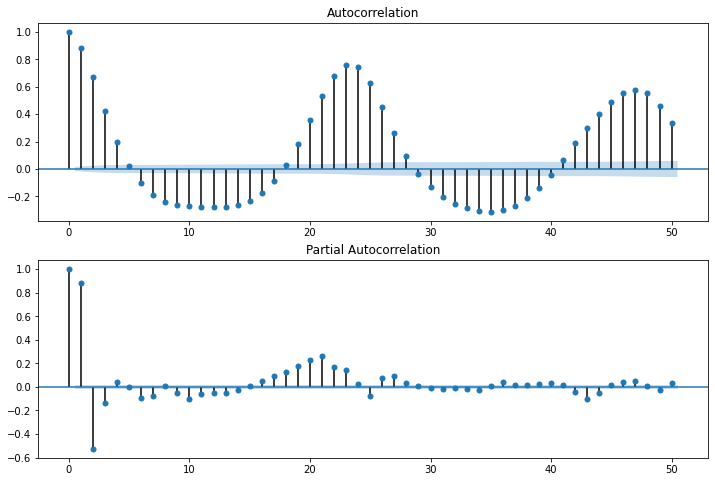

In [33]:
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rental_hour_log['log_value'], lags = 50, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rental_hour_log['log_value'], lags = 50, ax = ax2)

#### Part 2 : Auto-Regressive Model

For a value at time t, we assume that it is linearly dependent on the previous p lagged values and there is an error term associated with it.

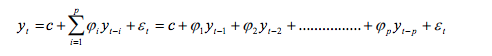

AR
It is similar to linear regression, where X is the p -lagged values and y is the value at time t. Here the order p can be chosen using ACF and PACF plots, or since we have enough data we assume it as a hyper-parameter.  Here, I break the dataset into 70%–30% training and testing dataset.

In [34]:
def AR_1(p,df_raw):

  df = df_raw.copy(deep = True)
  #Generating the lagged p terms
  for i in range(1,p+1):
    df['Shifted_values_%d' % i ] = df['log_value'].shift(i)

  df = df.dropna()
  #Breaking data set into test and training
  #dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(df.iloc[:, 0:12], df.iloc[:,12:], test_size = 0.3, random_state = 42)
  train_size = (int)(0.7 * df.shape[0])
  dfX_train = df.iloc[0:train_size,0:12]
  dfX_test = df.iloc[train_size:,0:12]
  dfy_train = df.iloc[0:train_size:,13:]
  dfy_test = df.iloc[train_size:,13:]

  y_train_tot = dfy_train['log_value']
  y_test_tot = dfy_test['log_value']
  y_train = dfy_train['Shifted_values_%d' % p]
  y_test = dfy_test['Shifted_values_%d' % p]

  y_train_tot = y_train_tot.values
  y_test_tot = y_test_tot.values
  X_train = dfX_train.values
  y_train = y_train.values
  X_test = dfX_test.values
  y_test = y_test.values
  #print(y_test_tot)
  #print(y_test)
  # display(dfy_test)
  # Running linear regression to generate the coefficents of lagged terms
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  #theta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
  theta  = lr.coef_.T
  #print('theta:',theta)
  intercept = lr.intercept_
  #print(intercept)
  train_pred = (X_train.dot(theta) + intercept) 
  y_train_s = np.column_stack([y_train_tot, train_pred])
  y_train_pred = pd.DataFrame(y_train_s)
  y_train_pred.columns = ['log_value', 'predicted_count_AR']
  #y_train_pred[['log_value','predicted_count_AR']].plot()

  test_pred = (X_test.dot(theta) + intercept) 
  y_test_s = np.column_stack([y_test_tot, test_pred])
  y_test_pred = pd.DataFrame(y_test_s)
  y_test_pred.columns = ['log_value', 'predicted_count_AR']
  #y_test_pred[['log_value','predicted_count_AR']].plot()

  # Merging predicted values to original DataFrame
  y = pd.concat([y_train_pred, y_test_pred])
  y.reset_index(drop = True, inplace = True)
  AR1_df = df.copy(deep = True)
  AR1_df['log_value'] = y['log_value']
  AR1_df['predicted_count_AR'] = y['predicted_count_AR']

  #RMSE = np.sqrt(mean_squared_error(y_test_pred['log_value'], y_test_pred['predicted_count_AR']))
  SSE = ((y_test_pred['predicted_count_AR'] - y_test_pred['log_value']) ** 2).sum()
  RMSE = math.sqrt(SSE/y_test_pred['log_value'].size)

  print("The RMSE is :", RMSE,", Value of p : ",p)
  #print(y_test_pred)
  #display(y_test_pred[['log_value','predicted_count_AR']].plot())
  return [AR1_df,theta,intercept,RMSE]

#### Part 3: Moving Average Model

Now that we have generated the coefficients and intercept, we can get our predictions. The error difference between the actual value and predicted value will form our residues.

Similar to the p, q is used here to denote the number of lagged observations. Again it can be thought of a linear regression with q-lagged errors as X and the error as y.

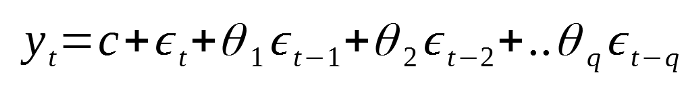

Where:

q is the order

c is a constant

epsilon is residuals (noise)

In [35]:
def MA_1(q,res):

  #res = df_AR.copy(deep = False)
  for i in range(1,q+1):
    res['Residual_shift_%d' % i ] = res['Residuals'].shift(i)

  res = res.dropna()
  #Breaking data set into test and training
  #dfX_train, dfX_test, dfy_train, dfy_test = train_test_split(df.iloc[:, 0:12], df.iloc[:,12:], test_size = 0.3, random_state = 42)
  train_size = (int)(0.7 * res.shape[0])
  dfX_train = res.iloc[0:train_size,0:12]
  dfX_test = res.iloc[train_size:,0:12]
  dfy_train = res.iloc[0:train_size:,13:]
  dfy_test = res.iloc[train_size:,13:]

  y_train_res = dfy_train['Residuals']
  y_test_res = dfy_test['Residuals']
  y_train = dfy_train['Residual_shift_%d' % q]
  y_test = dfy_test['Residual_shift_%d' % q]

  y_train_res = y_train_res.values
  y_test_res = y_test_res.values
  X_train = dfX_train.values
  y_train = y_train.values
  X_test = dfX_test.values
  y_test = y_test.values

  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  train_pred = -(X_train.dot(theta) + intercept) 
  y_train_s = np.column_stack([y_train_res, train_pred])
  y_train_pred = pd.DataFrame(y_train_s)
  y_train_pred.columns = ['Residuals', 'predicted_count_MA']
  #y_train_pred[['Residuals','predicted_count_MA']].plot()

  test_pred = -(X_test.dot(theta) + intercept) 
  y_test_s = np.column_stack([y_test_res, test_pred])
  y_test_pred = pd.DataFrame(y_test_s)
  y_test_pred.columns = ['Residuals', 'predicted_count_MA']
  #y_test_pred[['Residuals','predicted_count_MA']].plot()

  # Merging predicted values to original DataFrame
  y = pd.concat([y_train_pred, y_test_pred])
  y.reset_index(drop = True, inplace = True)
  MA1_df = res.copy(deep = True)
  MA1_df['Residuals'] = y['Residuals']
  MA1_df['predicted_count_MA'] = y['predicted_count_MA']

  #RMSE = np.sqrt(mean_squared_error(y_test_pred['Residuals'], y_test_pred['predicted_count_MA']))
  SSE = (y_test_pred['predicted_count_MA'] - y_test_pred['Residuals'])
  MSE = (SSE ** 2).sum()
  RMSE = math.sqrt(MSE/y_test_pred['Residuals'].size)

  print("The RMSE is :", RMSE,", Value of q : ",q)
  #print(y_test_pred)
  #display(y_test_pred[['Residuals','predicted_count_AR']].plot())
  return [MA1_df,RMSE]

#### Part 4: Merging AR and MA and getting back original data

We now make combine the two AR and MA model to get our predictions. 

Now, that the model building and prediction is done. Next step is reversing the steps performed for normalising (Taking log).



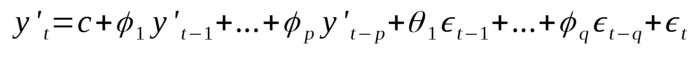

In [36]:
def ARIMA(rental_hour_pred):
  rental_hour_pred = rental_hour_MA1.copy(deep = True)
  rental_hour_pred['predicted_count'] = rental_hour_pred['predicted_count_MA']
  rental_hour_pred.log_value += np.log(rental_hour).shift(1).Actual_count
  rental_hour_pred.predicted_count += np.log(rental_hour).shift(1).Actual_count
  rental_hour_pred.log_value = np.exp(rental_hour_pred.Actual_count)
  rental_hour_pred.predicted_count = np.exp(rental_hour_pred.predicted_count)
  # rental_hour_pred[['Actual_count','predicted_count']].head()
  rental_hour_pred.iloc[13200:13400][['Actual_count','predicted_count']].plot()
  #rental_hour_pred[['Actual_count','predicted_count']].plot()
  SSE = ((rental_hour_pred['predicted_count'] - rental_hour_pred['Actual_count']) ** 2).sum()
  RMSE = math.sqrt((SSE/rental_hour_pred['Actual_count'].size)/4)
  print("RMSE score for ARMA Model:", RMSE)
  return RMSE

### Model Fitting and Prediction

As the permissible limit in PACF plot is too small to notice for the given data, it's hard to identify the cut-off value. Hence, we have calculated the error on the test-set for each p and picked the best one.



In [37]:
best_RMSE=100000000000
best_p = -1

for i in range(1,40):
  [rental_hour_AR1 ,theta1,intercept1,RMSE1] = AR_1(i,rental_hour_log)
  if(RMSE1<best_RMSE):
    best_RMSE = RMSE1
    best_p = i
  
print(best_p)

The RMSE is : 1.0544481346456434 , Value of p :  1
The RMSE is : 1.055438445265546 , Value of p :  2
The RMSE is : 1.0582379170744272 , Value of p :  3
The RMSE is : 1.0715497719479394 , Value of p :  4
The RMSE is : 1.1128048377417539 , Value of p :  5
The RMSE is : 1.1980351457835254 , Value of p :  6
The RMSE is : 1.3228958782537112 , Value of p :  7
The RMSE is : 1.44573636840174 , Value of p :  8
The RMSE is : 1.5602935677651435 , Value of p :  9
The RMSE is : 1.6676858882500925 , Value of p :  10
The RMSE is : 1.7671491695507588 , Value of p :  11
The RMSE is : 1.8486799566517715 , Value of p :  12
The RMSE is : 1.8972297488265655 , Value of p :  13
The RMSE is : 1.9225694399242654 , Value of p :  14
The RMSE is : 1.9695034172539498 , Value of p :  15
The RMSE is : 2.0436306029498326 , Value of p :  16
The RMSE is : 2.0415780572345246 , Value of p :  17
The RMSE is : 1.923644888850063 , Value of p :  18
The RMSE is : 1.6811496480625936 , Value of p :  19
The RMSE is : 1.380052821

From the above result we found that, the error is less at p = 35. We can also observe the same from the PACF plot at respective lagged value.

In [38]:
[rental_hour_AR1 ,theta1,intercept1,RMSE1] = AR_1(best_p,rental_hour_log)

The RMSE is : 1.0544481346456434 , Value of p :  1


In [39]:
rental_hour_AR1.dropna(inplace = True)

Next step is to calculate the Residuals. Residual is the difference between a value measured and the theoretical or true value. It's otherwise called as Noise.


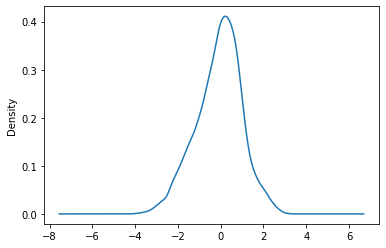

In [40]:
rental_hour_AR1['Residuals'] = rental_hour_AR1['log_value'] - rental_hour_AR1['predicted_count_AR']
rental_hour_AR1['Residuals'].plot(kind = 'kde')

Again, as the permissible limit is too small to notice, it's hard to identify the cut-off value. Hence, we have calculated the error on the test-set for each q and picked the best one.



In [41]:
best_RMSE=100000000000
best_q = -1

for i in range(1,30):
  [rental_hour_MA1,RMSE] = MA_1(i,rental_hour_AR1)
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

The RMSE is : 1.0582285466217587 , Value of q :  1
The RMSE is : 1.0733774756132979 , Value of q :  2
The RMSE is : 1.102247029452892 , Value of q :  3
The RMSE is : 1.1286484096051836 , Value of q :  4
The RMSE is : 1.1430612874681343 , Value of q :  5
The RMSE is : 1.137462393106519 , Value of q :  6
The RMSE is : 1.1168332351692176 , Value of q :  7
The RMSE is : 1.0958003210030336 , Value of q :  8
The RMSE is : 1.0949151817983358 , Value of q :  9
The RMSE is : 1.1063573018647959 , Value of q :  10
The RMSE is : 1.1212566840305673 , Value of q :  11
The RMSE is : 1.132612209553275 , Value of q :  12
The RMSE is : 1.138205332757614 , Value of q :  13
The RMSE is : 1.1398917485237279 , Value of q :  14
The RMSE is : 1.1389715257094783 , Value of q :  15
The RMSE is : 1.1474183946265 , Value of q :  16
The RMSE is : 1.194937562660205 , Value of q :  17
The RMSE is : 1.2409992968548347 , Value of q :  18
The RMSE is : 1.2369650021083218 , Value of q :  19
The RMSE is : 1.1708332134668

From the above result we found that, the error is less at p = 25. We can also observe the same from the ACF plot at respective lagged value.

In [42]:
[rental_hour_MA1,RMSE] = MA_1(best_q,rental_hour_AR1)

The RMSE is : 1.056505333181941 , Value of q :  25


In [43]:
rental_hour_MA1.dropna(inplace = True)

Now that we have predicted both AR and MA values, next step is to combine both and to predict the result.

RMSE score for ARMA Model: 46.77857719315711


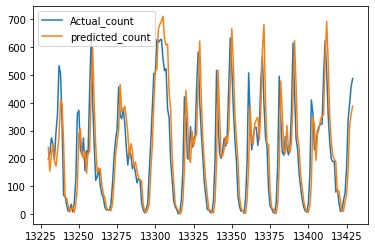

In [44]:
RMSE_Arima = ARIMA(rental_hour_MA1)

# **Section IV**
Comparing results and conclusive

This marks the end of this project. We began the project with dataset containing 16 features. After the data exploration and going through correlation, we removed the features which are found to be redundant and reduced the dimension to 13.

After data cleaning, we explored the data by visualizing to understand and gain insights from the data. Post which we build Regression models.

After training the data with the algorithms developed, we tested them against the test data.

Based on the prediction of rentals, we found the accuracy of models as,

  **RMSE Score of Linear Regression Model: 141.36** 
  
  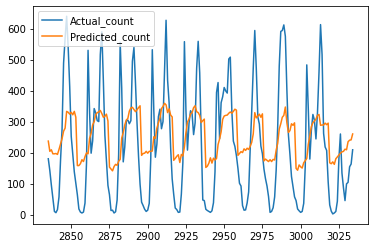

  **RMSE Score of Random Forest Model: 107.55**

  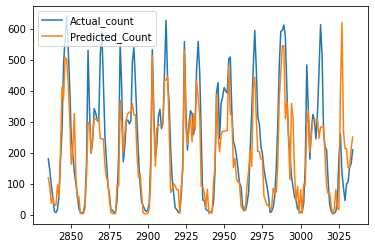

  **RMSE Score of ARMA Model: 46.77** 

  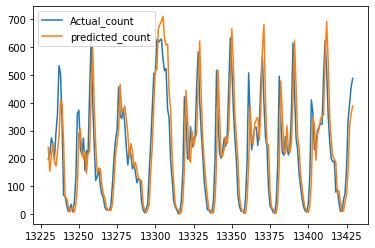

On comparing the above values, we can conclude that ARMA Model performs the best with RMSE value of 44.71 which is evident that ARMA performs the best for time series based data.

